# Fine Amount

In [4]:
!pip install --upgrade transformers datasets
!pip install matplotlib seaborn tqdm
!pip install --no-deps shap
!pip install multiprocess
!pip install --upgrade sympy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [5]:
# Mount Google Drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import time
import os
import json
import logging
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('TransformerRegressor')

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data directly from specified path
file_path = '/content/drive/MyDrive/Thesis/FINALDATASET.csv'
print(f"Loading data from specified path: {file_path}")

# Try different separators to load data
separators = [';', ',', '\t', '|']
df = None

for sep in separators:
    try:
        temp_df = pd.read_csv(file_path, sep=sep)
        if temp_df.shape[1] > 1:
            if df is None or temp_df.shape[1] > df.shape[1]:
                df = temp_df
                print(f"Successfully loaded data using separator '{sep}', detected {temp_df.shape[1]} columns")
                if temp_df.shape[1] > 20:  # If enough columns, consider the loading successful
                    break
    except Exception as e:
        print(f"Failed to load using separator '{sep}': {str(e)}")

# Set target variable to fine_amount
target_column = 'fine_amount'
print(f"\nSet target variable: {target_column}")
print(f"Target variable value distribution:\n{df[target_column].value_counts()}")

# TransformerRegressor class
class TransformerRegressor:
    def __init__(self, model_name="JQ1984/legalbert_gdpr_pretrained", output_dir="./results"):
        self.model_name = model_name
        self.output_dir = output_dir
        self.tokenizer = None
        self.model = None
        self.trainer = None
        self.train_time = None

        # Ensure output directory exists
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

    def _features_to_text(self, df):
        """Convert features to text descriptions for Transformer model processing"""
        texts = []
        for _, row in df.iterrows():
            text = ""
            for col, val in row.items():
                if isinstance(val, str):
                    text += f"{col} is {val}. "
                elif isinstance(val, (int, float)):
                    text += f"{col} value is {val}. "
            texts.append(text)
        return texts

    def prepare_data(self, df, target_column, test_size=0.2):
        logger.info(f"Preparing dataset, target column: {target_column}")

        # Handle potential NaN values
        logger.info("Checking and handling missing values")
        na_counts = df.isna().sum()
        if na_counts.sum() > 0:
            logger.info(f"Missing values found: \n{na_counts[na_counts > 0]}")
            for col in df.select_dtypes(include=['object']).columns:
                df[col] = df[col].fillna('')
            for col in df.select_dtypes(include=['number']).columns:
                if col != target_column:
                    df[col] = df[col].fillna(df[col].median())

        # Ensure target column is numeric
        df[target_column] = pd.to_numeric(df[target_column], errors='coerce')  # Convert to numeric, non-convertible values become NaN
        df[target_column] = df[target_column].fillna(df[target_column].median())  # Fill NaN values with median

        # Separate features and labels
        if target_column in df.columns:
            X = df.drop(target_column, axis=1)
            y = df[target_column]

            y_encoded = y.values

            # Convert features to text
            logger.info("Converting features to text descriptions")
            X_text = self._features_to_text(X)

            # Create training and testing indices
            indices = np.arange(len(X_text))
            train_indices, test_indices = train_test_split(
                indices, test_size=test_size, random_state=42
            )

            # Split data
            X_train = [X_text[i] for i in train_indices]
            X_test = [X_text[i] for i in test_indices]
            y_train = y_encoded[train_indices]
            y_test = y_encoded[test_indices]

            # Create datasets
            self.train_dataset = Dataset.from_dict({
                'text': X_train,
                'label': y_train
            })

            self.test_dataset = Dataset.from_dict({
                'text': X_test,
                'label': y_test
            })

            # Save test data for subsequent analysis
            self.X_test_original = X_test
            self.y_test = y_test

            logger.info(f"Training set size: {len(self.train_dataset)}, Test set size: {len(self.test_dataset)}")
            return True
        else:
            logger.error(f"Target column {target_column} not in dataset")
            return False

    def load_model(self):
        """Load pre-trained model and tokenizer"""
        logger.info(f"Loading model: {self.model_name}")
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            self.model = AutoModelForSequenceClassification.from_pretrained(
                self.model_name,
                num_labels=1  # For regression, we have only one output (fine_amount)
            )
            # Move model to GPU (if available)
            self.model.to(device)
            logger.info("Model loaded successfully")
        except Exception as e:
            logger.error(f"Error loading model: {str(e)}")
            raise

    def tokenize_data(self, max_length=256):
        """Tokenize the data"""
        logger.info(f"Tokenizing data, maximum length: {max_length}")

        def tokenize_function(examples):
            return self.tokenizer(
                examples['text'],
                padding="max_length",
                truncation=True,
                max_length=max_length,
                add_special_tokens=True
            )

        self.tokenized_train = self.train_dataset.map(tokenize_function, batched=True)
        self.tokenized_test = self.test_dataset.map(tokenize_function, batched=True)

    def train(self, epochs=5, batch_size=16, learning_rate=3e-5, weight_decay=0.01):
        """Train the model"""
        logger.info(f"Starting model training: epochs={epochs}, batch_size={batch_size}, learning_rate={learning_rate}, weight_decay={weight_decay}")

        # Training parameters
        training_args = TrainingArguments(
            output_dir=self.output_dir,
            num_train_epochs=epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            weight_decay=weight_decay,
            learning_rate=learning_rate,
            logging_dir=f"{self.output_dir}/logs",
            load_best_model_at_end=True,
            eval_strategy="epoch",
            save_strategy="epoch",
            metric_for_best_model="eval_loss",
            greater_is_better=False  # Regression, lower loss is better
        )

        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            predictions = logits.flatten()  # Flatten predictions
            mse = mean_squared_error(labels, predictions)
            mae = mean_absolute_error(labels, predictions)
            r2 = r2_score(labels, predictions)
            return {
                'mse': mse,
                'mae': mae,
                'r2': r2
            }

        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.tokenized_train,
            eval_dataset=self.tokenized_test,
            compute_metrics=compute_metrics,
        )

        # Record training time
        start_time = time.time()
        train_results = self.trainer.train()
        self.train_time = time.time() - start_time
        logger.info(f"Training completed, time taken: {self.train_time:.2f} seconds")

        # Save model and training results
        self.trainer.save_model(os.path.join(self.output_dir, "best_model"))
        self.trainer.log_metrics("train", train_results.metrics)
        self.trainer.save_metrics("train", train_results.metrics)
        self.trainer.save_state()

        logger.info(f"Model saved to: {os.path.join(self.output_dir, 'best_model')}")
        return train_results.metrics

    def evaluate(self, save_dir=None):
        """Evaluate model performance"""
        logger.info("Evaluating model performance")

        if save_dir is None:
            save_dir = self.output_dir

        eval_results = self.trainer.evaluate()
        logger.info(f"Evaluation results: {eval_results}")

        # Save evaluation results
        with open(os.path.join(save_dir, 'eval_results.json'), 'w') as f:
            json.dump(eval_results, f)

        # Get test set predictions
        predictions = self.trainer.predict(self.tokenized_test)
        preds = predictions.predictions.flatten()

        # Calculate regression evaluation metrics
        mse = mean_squared_error(self.y_test, preds)
        mae = mean_absolute_error(self.y_test, preds)
        r2 = r2_score(self.y_test, preds)

        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R² (coefficient of determination): {r2:.4f}")

        # Save results
        with open(os.path.join(save_dir, 'regression_results.json'), 'w') as f:
            json.dump({
                'mse': mse,
                'mae': mae,
                'r2': r2
            }, f)

        return eval_results


# Main function example:
if __name__ == "__main__":
    # Prepare data
    target_column = 'fine_amount'  # Target column is fine_amount for regression task

    # Initialize regression model
    output_dir = "./fine_amount_prediction"
    os.makedirs(output_dir, exist_ok=True)

    regressor = TransformerRegressor(
        model_name="nlpaueb/legal-bert-base-uncased",
        output_dir=output_dir
    )

    success = regressor.prepare_data(df, target_column)
    if not success:
        print("Unable to prepare data, please check target column")
        exit(1)

    # Load and train model
    regressor.load_model()
    regressor.tokenize_data(max_length=256)
    regressor.train(epochs=3, batch_size=16, learning_rate=3e-5)

    # Evaluate model performance
    regressor.evaluate(save_dir=output_dir)


Using device: cuda
Loading data from specified path: /content/drive/MyDrive/Thesis/FINALDATASET.csv
Successfully loaded data using separator ';', detected 26 columns

Set target variable: fine_amount
Target variable value distribution:
fine_amount
0              1338
2000             76
3000             46
5000             45
1000             41
               ... 
13000             1
96000             1
56000             1
1995              1
fine_amount       1
Name: count, Length: 279, dtype: int64


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Map:   0%|          | 0/1929 [00:00<?, ? examples/s]

Map:   0%|          | 0/483 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jonstark186 (jonstark186-tilburg-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Mse,Mae,R2
1,No log,29898044736536576.000000,29898046884020224.000000,13422664.000000,-0.006063
2,No log,29898044736536576.000000,29898046884020224.000000,13422664.000000,-0.006063
3,No log,29898044736536576.000000,29898046884020224.000000,13422664.000000,-0.006063


***** train metrics *****
  epoch                    =                3.0
  total_flos               =           709020GF
  train_loss               = 9074730622837886.0
  train_runtime            =         0:02:32.28
  train_samples_per_second =             38.002
  train_steps_per_second   =              2.384


Mean Squared Error (MSE): 29898044666962344.0000
Mean Absolute Error (MAE): 13422663.9038
R² (coefficient of determination): -0.0061


## Clean Data for other machine learning model

*   Random Forest
*   XG boost
*   Ensemble model





In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def clean_data(df, target_column):
    """ Data cleaning function, handles invalid values, missing values, outliers, etc. """
    # View basic information of original data
    print("Basic information of original data:")
    print(df.info())

    # 1. Process 'Affected_data_volume' column, replace 'unspecific' and NaN with 0
    df['Affected_data_volume'] = df['Affected_data_volume'].replace({'unspecific': np.nan})  # Replace 'unspecific' with NaN
    df['Affected_data_volume'] = pd.to_numeric(df['Affected_data_volume'], errors='coerce')  # Convert to numeric, values that can't be converted become NaN
    df['Affected_data_volume'] = df['Affected_data_volume'].fillna(0)  # Fill NaN values with 0

    # 2. Handle missing values: fill numeric columns with median, text columns with empty string
    print("\nHandling missing values:")
    na_counts = df.isna().sum()
    print(na_counts[na_counts > 0])  # Display columns with missing values

    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].fillna('')  # Fill text columns with empty string
    for col in df.select_dtypes(include=['number']).columns:
        if col != target_column:  # Don't process missing values in target column
            df[col] = df[col].fillna(df[col].median())  # Fill numeric columns with median

    # 3. Ensure target column is numeric and remove all non-numeric characters (e.g., spaces, symbols)
    df[target_column] = pd.to_numeric(df[target_column], errors='coerce')

    # 4. Apply logarithmic transformation (log(1+x)) to target column to avoid right skew
    df[target_column] = df[target_column].apply(lambda x: np.log1p(x) if x > 0 else 0)  # log(1+x) to avoid effect of 0

    # Handle outliers in target column: use IQR to remove large outliers
    q1 = df[target_column].quantile(0.25)
    q3 = df[target_column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df = df[(df[target_column] >= lower_bound) & (df[target_column] <= upper_bound)]

    # 5. Drop 'gdpr_clause' and 'gdpr_conflict' columns
    df = df.drop(columns=['gdpr_clause', 'gdpr_conflict'], axis=1)

    # 6. Apply Label Encoding to 'country' and 'company_industry'
    label_encoder = LabelEncoder()

    # Apply Label Encoding to 'country' column
    df['country'] = label_encoder.fit_transform(df['country'])

    # Apply Label Encoding to 'company_industry' column
    df['company_industry'] = label_encoder.fit_transform(df['company_industry'])

    # 7. Output information after data cleaning
    print("\nBasic information after data cleaning:")
    print(df.info())

    # Display first few rows after data cleaning
    print("\nFirst 5 rows after data cleaning:")
    print(df.head())

    return df

file_path = '/content/drive/MyDrive/Thesis/FINALDATASET.csv'

# Try different separators to load data
separators = [';', ',', '\t', '|']
df = None

for sep in separators:
    try:
        temp_df = pd.read_csv(file_path, sep=sep)
        if temp_df.shape[1] > 1:
            if df is None or temp_df.shape[1] > df.shape[1]:
                df = temp_df
                print(f"Successfully loaded data using separator '{sep}', detected {temp_df.shape[1]} columns")
                if temp_df.shape[1] > 20:  # If enough columns, consider the loading successful
                    break
    except Exception as e:
        print(f"Failed to load using separator '{sep}': {str(e)}")

if df is None or df.shape[1] <= 1:
    print("Cannot correctly load data, please check file format.")
else:
    # Display basic data information
    print(f"\nSuccessfully loaded dataset! Shape: {df.shape}")
    print("\nFirst 5 rows of dataset:")
    print(df.head())
    print("\nDataset information:")
    df.info()

    # Set target variable to fine_amount
    target_column = 'fine_amount'
    print(f"\nSet target variable: {target_column}")
    print(f"Target variable value distribution:\n{df[target_column].value_counts()}")

# Assume target column is 'fine_amount'
target_column = 'fine_amount'

# Call data cleaning function
cleaned_df = clean_data(df, target_column)

Successfully loaded data using separator ';', detected 26 columns

Successfully loaded dataset! Shape: (2412, 26)

First 5 rows of dataset:
  Affected_data_volume  Criminal_investigation_exception  Date  \
0           unspecific                                 0  2020   
1           unspecific                                 0  2020   
2           unspecific                                 0  2019   
3              1500000                                 0  2023   
4           unspecific                                 0  2019   

  company_industry      country  country_security_exception  \
0        Education  Netherlands                           0   
1    Public sector      Estonia                           0   
2        Marketing        Spain                           0   
3          Medical       France                           0   
4           Retail     Portugal                           0   

   data_category_Basic_personal_data  data_category_Children_data  \
0              

In [8]:
# Process cleaned_df, ensure all columns are numeric
import pandas as pd
import numpy as np

# Assuming your cleaned DataFrame is already named cleaned_df
# Here we use pd.to_numeric to force all columns to numeric type, non-numeric data that can't be converted will become NaN

for col in cleaned_df.columns:
    if cleaned_df[col].dtype == 'object':  # If it's a text type
        # Convert 'Not specified' or other non-numeric text to NaN
        cleaned_df[col] = cleaned_df[col].replace({'Not specified': np.nan})
        # Force convert column to numeric, values that can't be converted become NaN
        cleaned_df[col] = pd.to_numeric(cleaned_df[col], errors='coerce')

# Fill NaN values in numeric columns, using median here
for col in cleaned_df.select_dtypes(include=[np.number]).columns:
    cleaned_df[col] = cleaned_df[col].fillna(cleaned_df[col].median())

# If there are any text columns, fill with empty string
for col in cleaned_df.select_dtypes(include=['object']).columns:
    cleaned_df[col] = cleaned_df[col].fillna('')

# Check cleaned data
print("\nCleaned data (first 5 rows):")
print(cleaned_df.head())

print("\nData type information after cleaning:")
print(cleaned_df.info())

# When continuing with model training, you can directly use this cleaned_df for splitting and training


Cleaned data (first 5 rows):
   Affected_data_volume  Criminal_investigation_exception    Date  \
0                   0.0                                 0  2020.0   
1                   0.0                                 0  2020.0   
2                   0.0                                 0  2019.0   
3             1500000.0                                 0  2023.0   
4                   0.0                                 0  2019.0   

   company_industry  country  country_security_exception  \
0                 0       22                           0   
1                 8        8                           0   
2                 6       29                           0   
3                 7       11                           0   
4                 9       26                           0   

   data_category_Basic_personal_data  data_category_Children_data  \
0                                  1                            0   
1                                  0                    

## Random Forest Regression

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('RandomForestRegressor')

target_column = 'fine_amount'

# Split data into features (X) and target (y)
X = cleaned_df.drop(columns=[target_column])
y = cleaned_df[target_column]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Standardization (scaling features to mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
start_time = time.time()
rf_model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time
logger.info(f"Training completed, time taken: {train_time:.2f} seconds")

# Model evaluation
y_pred_rf = rf_model.predict(X_test_scaled)

# Calculate evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

logger.info(f"Mean Squared Error (MSE): {mse_rf:.4f}")
logger.info(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
logger.info(f"R² (coefficient of determination): {r2_rf:.4f}")

# Print evaluation results
print(f"Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"R² (coefficient of determination): {r2_rf:.4f}")


Mean Squared Error (MSE): 31.1213
Mean Absolute Error (MAE): 4.5237
R² (coefficient of determination): 0.0321


## Logarithmic transformation （best model）



In [10]:
# Apply logarithmic transformation to target variable (for right-skewed numeric data, to avoid negative or zero values in log)
y_log = np.log1p(y)  # Use log(1+x) to avoid negative or NaN values in log calculation

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Standardize features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
start_time = time.time()
rf_model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time
logger.info(f"Training completed, time taken: {train_time:.2f} seconds")

# Model evaluation
y_pred_rf = rf_model.predict(X_test_scaled)

# Calculate evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Inverse logarithmic transformation (convert predictions back to original scale)
y_pred_rf = np.expm1(y_pred_rf)  # expm1 is used for the inverse transformation of log(1+x)

logger.info(f"Mean Squared Error (MSE): {mse_rf:.4f}")
logger.info(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
logger.info(f"R² (coefficient of determination): {r2_rf:.4f}")

# Print evaluation results
print(f"Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"R² (coefficient of determination): {r2_rf:.4f}")

Mean Squared Error (MSE): 1.3519
Mean Absolute Error (MAE): 0.9839
R² (coefficient of determination): 0.0773


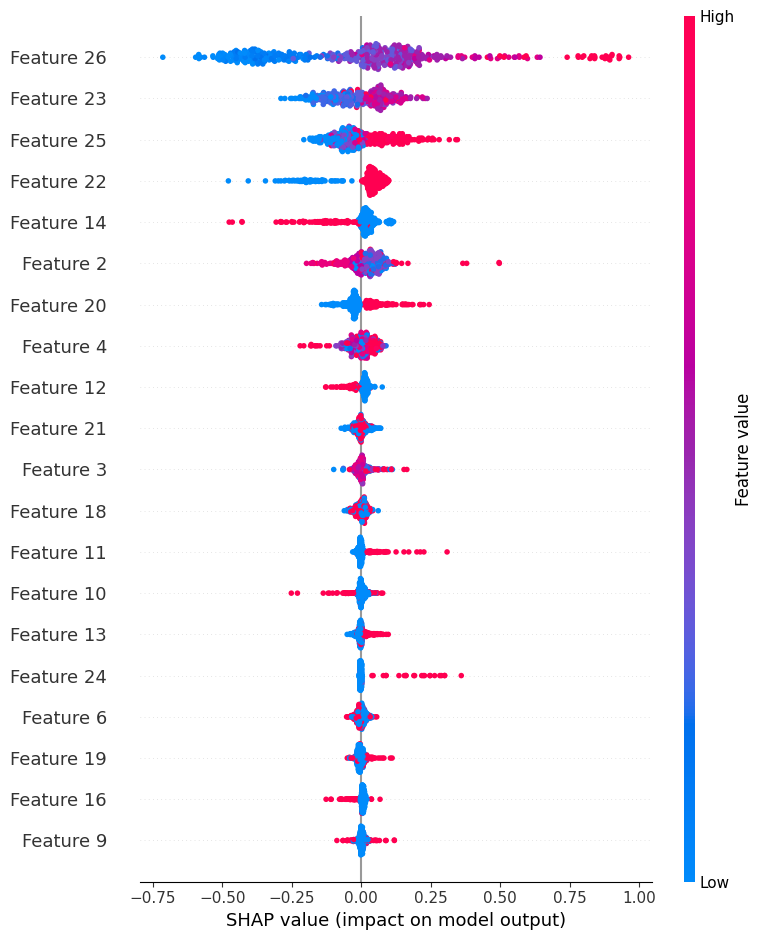

In [15]:
# Import SHAP
import shap

# Create an explainer object for the Random Forest model
explainer_rf = shap.Explainer(rf_model, X_train_scaled)

# Compute SHAP values for the test set
shap_values_rf = explainer_rf(X_test_scaled)

# Visualize SHAP values using summary plot
shap.summary_plot(shap_values_rf, X_test_scaled)

# Visualize SHAP values for a specific instance (e.g., first instance)
shap.initjs()  # This will enable interactive visualizations
shap.force_plot(shap_values_rf[0], X_test_scaled[0])

## XGboost

In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import time

# Assume cleaned_df is your cleaned DataFrame

# Apply logarithmic transformation to target variable (log(1+x) to avoid negative or zero values)
y_log = np.log1p(cleaned_df['fine_amount'])

# Separate features and target
X = cleaned_df.drop(columns=['fine_amount'])
y = y_log

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize XGBoost regression model
xgboost_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Set hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

# Train model and tune hyperparameters
start_time = time.time()
grid_search.fit(X_train_scaled, y_train)
train_time = time.time() - start_time
print(f"Training completed, time taken: {train_time:.2f} seconds")

# Get best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Evaluate model using best hyperparameters
best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

# Calculate evaluation metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print evaluation results
print(f"Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"R² (coefficient of determination): {r2_xgb:.4f}")

# Inverse logarithmic transformation (convert predictions back to original scale)
y_pred_xgb_orig = np.expm1(y_pred_xgb)  # expm1 for inverse transformation of log(1+x)

# Evaluation metrics after inverse transformation
mse_xgb_orig = mean_squared_error(np.expm1(y_test), y_pred_xgb_orig)
mae_xgb_orig = mean_absolute_error(np.expm1(y_test), y_pred_xgb_orig)
r2_xgb_orig = r2_score(np.expm1(y_test), y_pred_xgb_orig)

print(f"Mean Squared Error (MSE) after inverse transformation: {mse_xgb_orig:.4f}")
print(f"Mean Absolute Error (MAE) after inverse transformation: {mae_xgb_orig:.4f}")
print(f"R² (coefficient of determination) after inverse transformation: {r2_xgb_orig:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Training completed, time taken: 24.75 seconds
Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
Mean Squared Error (MSE): 1.2401
Mean Absolute Error (MAE): 1.0084
R² (coefficient of determination): 0.1537
Mean Squared Error (MSE) after inverse transformation: 35.3469
Mean Absolute Error (MAE) after inverse transformation: 4.4180
R² (coefficient of determination) after inverse transformation: -0.0993


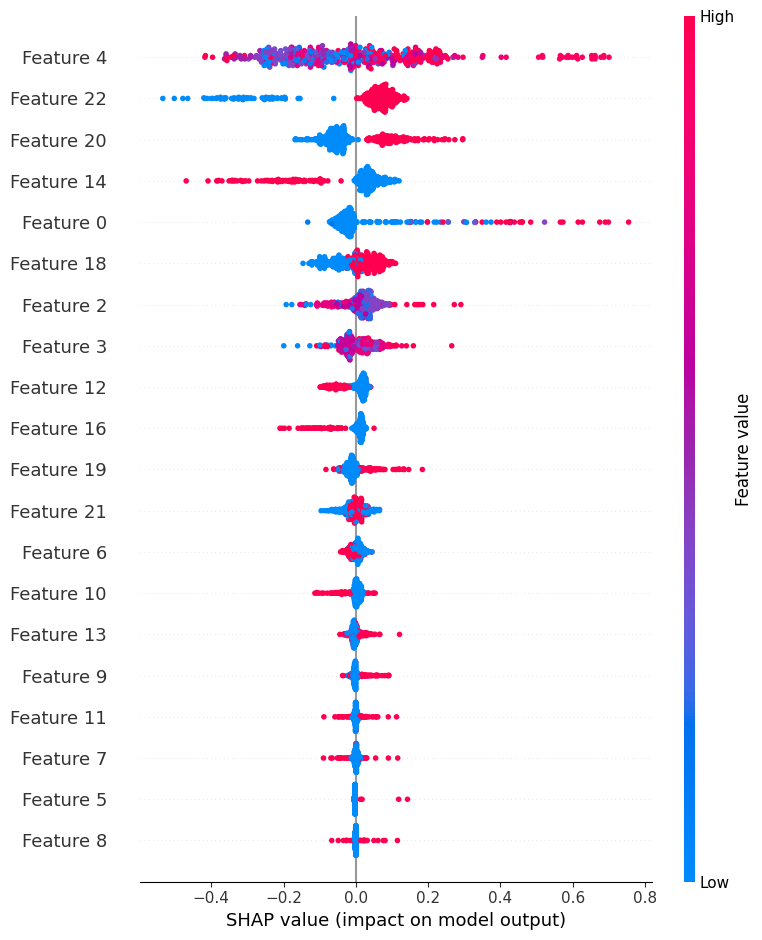

In [12]:
# Install SHAP
!pip install shap

# Import SHAP
import shap

# Create an explainer object for the model
explainer = shap.Explainer(best_xgb_model, X_train_scaled)

# Compute SHAP values for the test set
shap_values = explainer(X_test_scaled)

# Visualize SHAP values using summary plot
shap.summary_plot(shap_values, X_test_scaled)

# You can also visualize the SHAP values for a specific instance (e.g., first instance)
shap.initjs()  # This will enable interactive visualizations
shap.force_plot(shap_values[0], X_test_scaled[0])


In [ ]:
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import time

# Assume cleaned_df is your cleaned DataFrame

# Apply logarithmic transformation to target variable (log(1+x) to avoid negative or zero values)
y_log = np.log1p(cleaned_df['fine_amount'])

# Separate features and target
X = cleaned_df.drop(columns=['fine_amount'])
y = y_log

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize individual models
rf_model = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
knn_model = KNeighborsRegressor(n_neighbors=16)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=300, max_depth=6, learning_rate=0.01, random_state=42)

# Use voting ensemble model
voting_regressor = VotingRegressor(estimators=[('rf', rf_model), ('knn', knn_model), ('xgb', xgb_model)])

# Train ensemble model
start_time = time.time()
voting_regressor.fit(X_train_scaled, y_train)
train_time = time.time() - start_time
print(f"Training completed, time taken: {train_time:.2f} seconds")

# Make predictions using ensemble model
y_pred_voting = voting_regressor.predict(X_test_scaled)

# Calculate evaluation metrics
mse_voting = mean_squared_error(y_test, y_pred_voting)
mae_voting = mean_absolute_error(y_test, y_pred_voting)
r2_voting = r2_score(y_test, y_pred_voting)

# Print evaluation results
print(f"Mean Squared Error (MSE): {mse_voting:.4f}")
print(f"Mean Absolute Error (MAE): {mae_voting:.4f}")
print(f"R² (coefficient of determination): {r2_voting:.4f}")

# Inverse logarithmic transformation (convert predictions back to original scale)
y_pred_voting_orig = np.expm1(y_pred_voting)  # expm1 for inverse transformation of log(1+x)

# Evaluation metrics after inverse transformation
mse_voting_orig = mean_squared_error(np.expm1(y_test), y_pred_voting_orig)
mae_voting_orig = mean_absolute_error(np.expm1(y_test), y_pred_voting_orig)
r2_voting_orig = r2_score(np.expm1(y_test), y_pred_voting_orig)

print(f"Mean Squared Error (MSE) after inverse transformation: {mse_voting_orig:.4f}")
print(f"Mean Absolute Error (MAE) after inverse transformation: {mae_voting_orig:.4f}")
print(f"R² (coefficient of determination) after inverse transformation: {r2_voting_orig:.4f}")

Training completed, time taken: 1.41 seconds
Mean Squared Error (MSE): 1.2767
Mean Absolute Error (MAE): 1.0281
R² (coefficient of determination): 0.1287
Mean Squared Error (MSE) after inverse transformation: 35.8904
Mean Absolute Error (MAE) after inverse transformation: 4.5038
R² (coefficient of determination) after inverse transformation: -0.1162


## Feature Engineering

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assume cleaned_df is your cleaned DataFrame

# 1. Violation Nature weighted feature
violation_columns = [
    'violation_nature_Breach_of_Data_processing_principle',
    'violation_nature_Breach_of_data_security',
    'violation_nature_Violation_of_Data_processing_obligation',
    'violation_nature_Violation_of_data_subject_rights'
]

weights = {
    'violation_nature_Breach_of_Data_processing_principle': 1.5,
    'violation_nature_Breach_of_data_security': 1.5,
    'violation_nature_Violation_of_Data_processing_obligation': 1.0,
    'violation_nature_Violation_of_data_subject_rights': 1.2
}

# Create a new feature 'violation_severity' indicating the severity of violations
cleaned_df['violation_severity'] = sum(
    cleaned_df[col] * weights[col] for col in violation_columns
)

# 2. Affected subjects volume (affected_data_volume) as a feature
# Assume 'affected_data_volume' is an already prepared feature
# Add it directly to the dataset as a feature
cleaned_df['affected_data_volume'] = cleaned_df['Affected_data_volume']  # Assume this column exists in the original data

# 3. Industry fine trends
industry_avg_fines = cleaned_df.groupby('company_industry')['fine_amount'].mean()
cleaned_df['industry_avg_fine'] = cleaned_df['company_industry'].map(industry_avg_fines)

# 4. Country fine trends
country_avg_fines = cleaned_df.groupby('country')['fine_amount'].mean()
cleaned_df['country_avg_fine'] = cleaned_df['country'].map(country_avg_fines)

# 5. Time (Date) features
# Assume Date is the year, which can be used directly as a feature
# If you believe certain years lead to higher fines, you can create dummy variables for specific years
cleaned_df['is_recent_year'] = (cleaned_df['Date'] > 2020).astype(int)

# 6. Feature selection and data standardization
X = cleaned_df.drop(columns=['fine_amount'])  # Remove target variable
y = np.log1p(cleaned_df['fine_amount'])  # Apply log transformation to target

# Data standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 7. Data splitting
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 8. Train using Random Forest regression model (can try other models)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# 9. Model evaluation
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² (coefficient of determination): {r2:.4f}")

# 10. Inverse logarithmic transformation (convert predictions back to original scale)
y_pred_orig = np.expm1(y_pred)  # expm1 for inverse transformation of log(1+x)

# Evaluation metrics after inverse transformation
mse_orig = mean_squared_error(np.expm1(y_test), y_pred_orig)
mae_orig = mean_absolute_error(np.expm1(y_test), y_pred_orig)
r2_orig = r2_score(np.expm1(y_test), y_pred_orig)

print(f"Mean Squared Error (MSE) after inverse transformation: {mse_orig:.4f}")
print(f"Mean Absolute Error (MAE) after inverse transformation: {mae_orig:.4f}")
print(f"R² (coefficient of determination) after inverse transformation: {r2_orig:.4f}")

Mean Squared Error (MSE): 1.3066
Mean Absolute Error (MAE): 0.9869
R² (coefficient of determination): 0.1083
Mean Squared Error (MSE) after inverse transformation: 34.9098
Mean Absolute Error (MAE) after inverse transformation: 4.3270
R² (coefficient of determination) after inverse transformation: -0.0857


In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import pandas as pd
import numpy as np

# Select features and target variable
X = cleaned_df.drop(columns=['fine_amount'])  # Remove target variable
y = np.log1p(cleaned_df['fine_amount'])  # Apply log transformation to target

# Data splitting: training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning: Use GridSearchCV to adjust XGBoost hyperparameters

# Define XGBoost regression model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Set hyperparameter ranges for fine-tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Use GridSearch for hyperparameter optimization
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Train model
grid_search.fit(X_train_scaled, y_train)

# Output best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Train final model using best hyperparameters
best_model = grid_search.best_estimator_

# 6. Model evaluation: Make predictions on test set and calculate evaluation metrics
y_pred = best_model.predict(X_test_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² (coefficient of determination): {r2:.4f}")

# 7. Inverse logarithmic transformation (convert predictions back to original scale)
y_pred_orig = np.expm1(y_pred)  # expm1 for inverse transformation of log(1+x)

# Evaluation metrics after inverse transformation
mse_orig = mean_squared_error(np.expm1(y_test), y_pred_orig)
mae_orig = mean_absolute_error(np.expm1(y_test), y_pred_orig)
r2_orig = r2_score(np.expm1(y_test), y_pred_orig)

print(f"Mean Squared Error (MSE) after inverse transformation: {mse_orig:.4f}")
print(f"Mean Absolute Error (MAE) after inverse transformation: {mae_orig:.4f}")
print(f"R² (coefficient of determination) after inverse transformation: {r2_orig:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Mean Squared Error (MSE): 1.2473
Mean Absolute Error (MAE): 0.9847
R² (coefficient of determination): 0.1488
Mean Squared Error (MSE) after inverse transformation: 35.0275
Mean Absolute Error (MAE) after inverse transformation: 4.3610
R² (coefficient of determination) after inverse transformation: -0.0893
